In [1]:
import paths
import numpy as np
import numpy.random as npr
import h5py
import GPy
import ckli.mapest as mapest
import ckli.ckliest as ckliest
from sdfs.geom_mrst import geom_plot, GeomMRST
from sdfs.bc_mrst import BCMRST
from sdfs.darcy import DarcyExp
from sdfs.tpfa import TPFA
from time import perf_counter

In [2]:
from matplotlib import pyplot as plt, collections as mc, patches as mpatches, cm, ticker
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
plt.rc('text', usetex=True)
plt.rc('image', cmap='coolwarm')

In [4]:
data_path = '../data/'
geom_filename = data_path + f'geom_1x.mat'
bc_filename = data_path + f'bc_1x.mat'
conduct_filename = data_path + f'conduct_log_1x.mat'
well_cells_filename = data_path + f'well_cells_1x.mat'
yobs_filename = data_path + f'yobs_200_1x.npy'

In [5]:
with h5py.File(conduct_filename, 'r') as f:
    ytrue = f.get('conduct_log')[:].ravel()

with h5py.File(well_cells_filename, 'r') as f:
    iuobs = f.get('well_cells')[:].ravel() - 1

iyobs = np.load(yobs_filename)

In [6]:
ytm = np.mean(ytrue)
yref = ytrue - ytm

In [7]:
geom = GeomMRST(geom_filename)
bc = BCMRST(geom, bc_filename)
bc.rescale('N', ytm)

Nc = geom.cells.num
Ninf = geom.faces.num_interior

prob = DarcyExp(TPFA(geom, bc), iuobs)
uref = prob.solve(yref)
uobs = uref[iuobs]
Nuobs = iuobs.size

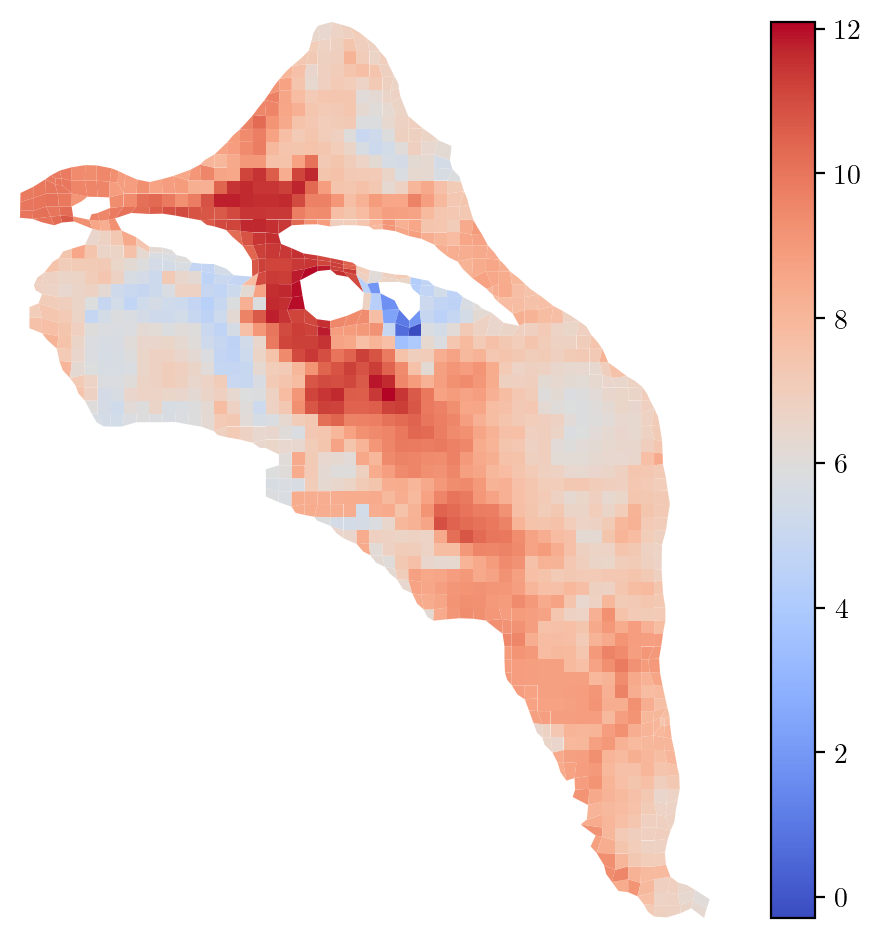

In [8]:
fig, ax = plt.subplots()
plot = geom_plot(geom, ytm + yref, ax)
ax.set_aspect('equal')
ax.axis('off')
ax.autoscale(tight=True)
fig.colorbar(plot, ax=ax)
fig.tight_layout()

In [9]:
std_dev_ref = 1.0
cor_len_ref = 0.1
iylearn = iyobs[0]
ylearn = yref[iylearn]
mflearn = GPy.mappings.Constant(2, 1, value=1)
klearn = GPy.kern.sde_Matern52(input_dim=2, variance=std_dev_ref**2, lengthscale=cor_len_ref)
mylearn = GPy.models.GPRegression(geom.cells.centroids[:, iylearn].T, ylearn[:, None], klearn, noise_var=np.sqrt(np.finfo(float).eps), mean_function=mflearn)
mylearn.optimize(messages=True, ipython_notebook=False)
print(klearn)
print(mflearn)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0003   5.346180e+02   1.265020e+06 
    00s06  0008   3.219412e+02   2.979142e+03 
    00s09  0011   2.965921e+02   1.766766e+02 
    00s15  0018   2.947365e+02   1.272526e-04 
    00s16  0020   2.947365e+02   7.226858e-08 
Runtime:     00s16
Optimization status: Converged

  Mat52.       |                value  |  constraints  |  priors
  variance     |    2.289380366048906  |      +ve      |        
  lengthscale  |  0.02631597204948108  |      +ve      |        
  constmap.  |                 value  |  constraints  |  priors
  C          |  0.057578418259001576  |               |        


In [10]:
ypred  = mylearn.constmap.C.values[0] * np.ones_like(yref)
Cypred = mylearn.kern.K(geom.cells.centroids.T)

In [11]:
Nxi = 1000
Psi_y, Lambda_y = ckliest.KL_via_eigh(Cypred, Nxi)

In [12]:
seed = 0
rs = npr.RandomState(seed)
Nens = 20000
xi_ens   = np.zeros((Nens, Nxi))
ytms_ens = np.zeros((Nens, geom.cells.num))
u_ens    = np.zeros((Nens, geom.cells.num))

In [13]:
ts = perf_counter()
for i in range(Nens):
    xi_ens[i] = rs.standard_normal(Nxi)
    ytms_ens[i] = ypred + Psi_y @ xi_ens[i]
    u_ens[i] = prob.solve(ytms_ens[i])
print(f'{perf_counter() - ts} s')

77.58704383400618 s


In [14]:
with h5py.File('../data/mpi23_ens_data.h5', 'w') as f:
    f.create_dataset('xi_ens', data=xi_ens)
    f.create_dataset('ytms_ens', data=ytms_ens)
    f.create_dataset('u_ens', data=u_ens)
    f.create_dataset('ytm', data=ytm)
    f.create_dataset('yref', data=yref)
    f.create_dataset('ypred', data=ypred)
    f.create_dataset('Psi_y', data=Psi_y)
    f.create_dataset('Nens', data=Nens)
    f.create_dataset('Nxi', data=Nxi)